In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/normal/normal/45.4656.csv
/kaggle/input/normal/normal/28.8768.csv
/kaggle/input/normal/normal/37.6832.csv
/kaggle/input/normal/normal/56.7296.csv
/kaggle/input/normal/normal/16.1792.csv
/kaggle/input/normal/normal/32.9728.csv
/kaggle/input/normal/normal/58.7776.csv
/kaggle/input/normal/normal/39.3216.csv
/kaggle/input/normal/normal/44.6464.csv
/kaggle/input/normal/normal/49.5616.csv
/kaggle/input/normal/normal/57.9584.csv
/kaggle/input/normal/normal/34.2016.csv
/kaggle/input/normal/normal/36.4544.csv
/kaggle/input/normal/normal/46.2848.csv
/kaggle/input/normal/normal/51.8144.csv
/kaggle/input/normal/normal/15.1552.csv
/kaggle/input/normal/normal/54.6816.csv
/kaggle/input/normal/normal/48.9472.csv
/kaggle/input/normal/normal/47.7184.csv
/kaggle/input/normal/normal/43.6224.csv
/kaggle/input/normal/normal/20.2752.csv
/kaggle/input/normal/normal/27.4432.csv
/kaggle/input/normal/normal/60.416.csv
/kaggle/input/normal/normal/35.4304.csv
/kaggle/input/normal/normal/40.3456.csv
/

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from scipy import stats,signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
import xgboost as xgb
from xgboost import XGBClassifier

In [6]:
def dataReader(path_names):
    data_n = pd.DataFrame()
    for i in path_names:
        low_data = pd.read_csv(i,header=None)
        data_n = pd.concat([data_n,low_data],ignore_index=True)
    return data_n


normal_file_names = glob.glob("/kaggle/input/normal/normal/*.csv")
data_normal = dataReader(normal_file_names)

# File paths for horizontal misalignment
horizontal_misalignment_file_names_0_5mm = glob.glob("/kaggle/input/horizontal-misalignment/horizontal-misalignment/0.5mm/*.csv")
horizontal_misalignment_file_names_1_0mm = glob.glob("/kaggle/input/horizontal-misalignment/horizontal-misalignment/1.0mm/*.csv")
horizontal_misalignment_file_names_1_5mm = glob.glob("/kaggle/input/horizontal-misalignment/horizontal-misalignment/1.5mm/*.csv")
horizontal_misalignment_file_names_2_0mm = glob.glob("/kaggle/input/horizontal-misalignment/horizontal-misalignment/2.0mm/*.csv")

# Read data for all horizontal misalignment file paths
data_horizontal_misalignment_0_5mm = dataReader(horizontal_misalignment_file_names_0_5mm)
data_horizontal_misalignment_1_0mm = dataReader(horizontal_misalignment_file_names_1_0mm)
data_horizontal_misalignment_1_5mm = dataReader(horizontal_misalignment_file_names_1_5mm)
data_horizontal_misalignment_2_0mm = dataReader(horizontal_misalignment_file_names_2_0mm)

In [7]:
# Define the number of samples to extract
num_samples = 7750000

data_normal_subset_train = data_normal[:num_samples]
data_horizontal_misalignment_0_5mm_subset_train = data_horizontal_misalignment_0_5mm[:num_samples]
data_horizontal_misalignment_1_0mm_subset_train = data_horizontal_misalignment_1_0mm[:num_samples]
data_horizontal_misalignment_1_5mm_subset_train = data_horizontal_misalignment_1_5mm[:num_samples]
data_horizontal_misalignment_2_0mm_subset_train = data_horizontal_misalignment_2_0mm[:num_samples]

# Define the features list
features_list = ["Tachometer", "UBA_axial", "UBA_radial", "UBA_tangential", "OBA_axial", "OBA_radial", "OBA_tangential", "Microphone"]

# Assign column names to each subset
data_normal_subset_train.columns = features_list

data_horizontal_misalignment_0_5mm_subset_train.columns = features_list
data_horizontal_misalignment_1_0mm_subset_train.columns = features_list
data_horizontal_misalignment_1_5mm_subset_train.columns = features_list
data_horizontal_misalignment_2_0mm_subset_train.columns = features_list


In [8]:
def extract_features(signal):
    mean = np.mean(signal)
    var = np.var(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    freq, psd = welch(signal)
    dominant_freq = freq[np.argmax(psd)]
    return [mean, var, skewness, kurt, dominant_freq]

df = pd.DataFrame()
def feature_extraction_window(data,fault,step_size):
    window_length = 125000    
    results = []
    
    for start in range(0, len(data) - window_length + 1, step_size):
        window = data.iloc[start:start + window_length]
        window_features = {}
        for column in features_list:
            # Extract signal values
            signal = window[column].values
            
            # Compute features
            features = extract_features(signal)
            window_features.update({
                f"{column}_Mean": features[0],
                f"{column}_Variance": features[1],
                f"{column}_Skewness": features[2],
                f"{column}_Kurtosis": features[3],
                f"{column}_Dominant_Frequency": features[4],
            })
        results.append(window_features)
    
    features_df = pd.DataFrame(results)
    features_df['Fault'] = fault
    return pd.concat([df,features_df],ignore_index=True)

In [9]:
df = feature_extraction_window(data_normal_subset_train,0,1000)
df.sample(10)

,Tachometer_Mean,Tachometer_Variance,Tachometer_Skewness,Tachometer_Kurtosis,Tachometer_Dominant_Frequency,UBA_axial_Mean,UBA_axial_Variance,UBA_axial_Skewness,UBA_axial_Kurtosis,UBA_axial_Dominant_Frequency,...,OBA_tangential_Variance,OBA_tangential_Skewness,OBA_tangential_Kurtosis,OBA_tangential_Dominant_Frequency,Microphone_Mean,Microphone_Variance,Microphone_Skewness,Microphone_Kurtosis,Microphone_Dominant_Frequency,Fault
2966,0.004487,2.957663,2.174638,2.764962,0.003906,0.013837,0.690145,-0.444455,-0.414767,0.441406,...,0.097799,-0.035059,-0.108788,0.054688,0.012373,0.031195,0.546709,-0.181269,0.441406,0
7433,-0.002291,2.826864,2.254240,3.139914,0.003906,0.007913,0.937670,-0.362044,-0.103336,0.441406,...,0.151535,0.001753,0.144916,0.003906,0.009647,0.028940,0.530923,0.201392,0.441406,0
6088,0.003127,3.041523,2.118548,2.521338,0.003906,0.012752,0.500582,-0.440322,-0.173889,0.441406,...,0.295907,0.070350,-0.523096,0.054688,0.011891,0.035973,0.506739,-0.269756,0.441406,0
7072,-0.003543,2.917895,2.201563,2.884085,0.003906,0.002770,0.744316,-0.481234,-0.483113,0.441406,...,0.074777,0.092377,-0.042469,0.054688,0.012740,0.029826,0.561426,-0.175641,0.441406,0
5187,-0.003970,2.767705,2.307437,3.365995,0.003906,0.009219,0.979546,-0.439155,-0.713673,0.441406,...,0.033932,-0.038099,0.174541,0.054688,0.013700,0.018092,0.624497,0.005517,0.441406,0
948,0.014180,2.891328,2.212504,2.947835,0.003906,0.001691,0.911701,-0.372415,-0.328622,0.441406,...,0.129528,-0.007356,0.651355,0.003906,0.012903,0.027610,0.511363,0.158678,0.441406,0
2777,-0.005662,2.921019,2.199534,2.875267,0.003906,0.001209,0.696239,-0.486425,-0.462649,0.441406,...,0.082283,-0.136334,-0.005279,0.054688,0.012197,0.030255,0.554037,-0.169117,0.441406,0
999,0.011525,2.672716,2.377145,3.697028,0.003906,-0.003235,1.301065,-0.338376,-0.987776,0.441406,...,0.074139,0.337598,0.465813,0.003906,0.013980,0.016166,0.619771,-0.039920,0.441406,0
163,-0.005678,2.980301,2.158392,2.696091,0.003906,0.011674,0.639512,-0.409972,-0.139847,0.441406,...,0.194483,-0.058626,-0.136087,0.003906,0.012199,0.035496,0.502897,-0.180339,0.441406,0
861,-0.002450,3.128605,2.062331,2.286310,0.003906,0.002482,0.309939,-0.182621,-0.126191,0.003906,...,0.202760,0.004994,-0.193548,0.003906,0.011603,0.043297,0.429551,-0.504121,0.441406,0


In [10]:
df.shape

(7626, 41)

In [11]:
df.describe()

,Tachometer_Mean,Tachometer_Variance,Tachometer_Skewness,Tachometer_Kurtosis,Tachometer_Dominant_Frequency,UBA_axial_Mean,UBA_axial_Variance,UBA_axial_Skewness,UBA_axial_Kurtosis,UBA_axial_Dominant_Frequency,...,OBA_tangential_Variance,OBA_tangential_Skewness,OBA_tangential_Kurtosis,OBA_tangential_Dominant_Frequency,Microphone_Mean,Microphone_Variance,Microphone_Skewness,Microphone_Kurtosis,Microphone_Dominant_Frequency,Fault
count,7626.000000,7626.000000,7626.000000,7626.000000,7626.000000,7626.000000,7626.000000,7626.000000,7626.000000,7626.000000,...,7626.000000,7626.000000,7626.000000,7626.000000,7626.000000,7626.000000,7626.000000,7626.000000,7626.000000,7626.0
mean,0.000361,2.980038,2.161621,2.720352,0.003906,0.006943,0.647866,-0.360790,-0.240929,0.298614,...,0.180270,0.054390,0.015676,0.021170,0.012217,0.033955,0.507314,-0.206253,0.441406,0.0
std,0.003742,0.147344,0.102050,0.460062,0.000000,0.006384,0.306223,0.104426,0.349928,0.205153,...,0.115966,0.222572,0.593396,0.023975,0.001573,0.008289,0.080297,0.310079,0.000000,0.0
min,-0.013180,2.507807,2.027430,2.143660,0.003906,-0.009677,0.307199,-0.488673,-1.008277,0.003906,...,0.024773,-2.042104,-0.958877,0.003906,0.007511,0.013344,0.247419,-0.520673,0.441406,0.0
25%,-0.002130,2.923448,2.084631,2.379376,0.003906,0.002853,0.434733,-0.449522,-0.469861,0.003906,...,0.100544,-0.044817,-0.205711,0.003906,0.011411,0.029680,0.449007,-0.381732,0.441406,0.0
50%,0.000471,3.010700,2.138331,2.607931,0.003906,0.005870,0.551696,-0.373495,-0.181412,0.441406,...,0.176850,0.054125,-0.069075,0.003906,0.012007,0.035575,0.498095,-0.247932,0.441406,0.0
75%,0.002511,3.093615,2.197203,2.866270,0.003906,0.010643,0.783142,-0.314121,0.004541,0.441406,...,0.214020,0.138453,0.083056,0.054688,0.012761,0.040807,0.552323,-0.129693,0.441406,0.0
max,0.016172,3.187413,2.505234,4.328040,0.003906,0.039344,1.726095,-0.043417,0.993194,0.441406,...,0.867328,1.290067,9.284907,0.054688,0.019470,0.046130,0.747664,1.675289,0.441406,0.0


In [12]:
# Perform feature extraction for each horizontal misalignment subset
df = feature_extraction_window(data_horizontal_misalignment_0_5mm_subset_train, 1, 3750)
df = feature_extraction_window(data_horizontal_misalignment_1_0mm_subset_train, 1, 3750)
df = feature_extraction_window(data_horizontal_misalignment_1_5mm_subset_train, 1, 3750)
df = feature_extraction_window(data_horizontal_misalignment_2_0mm_subset_train, 1, 3750)

# Display 20 random samples from the last processed DataFrame
df.sample(20)

,Tachometer_Mean,Tachometer_Variance,Tachometer_Skewness,Tachometer_Kurtosis,Tachometer_Dominant_Frequency,UBA_axial_Mean,UBA_axial_Variance,UBA_axial_Skewness,UBA_axial_Kurtosis,UBA_axial_Dominant_Frequency,...,OBA_tangential_Variance,OBA_tangential_Skewness,OBA_tangential_Kurtosis,OBA_tangential_Dominant_Frequency,Microphone_Mean,Microphone_Variance,Microphone_Skewness,Microphone_Kurtosis,Microphone_Dominant_Frequency,Fault
5195,-0.004617,2.771725,2.304462,3.352041,0.003906,0.012083,0.964178,-0.436872,-0.717564,0.441406,...,0.034728,-0.025635,0.147042,0.054688,0.013457,0.017913,0.611006,-0.028987,0.441406,0
2557,-0.001773,3.153611,2.046224,2.219453,0.003906,0.004416,0.331240,-0.213504,-0.058560,0.003906,...,0.244458,0.250149,0.378327,0.003906,0.011420,0.043810,0.427663,-0.505419,0.441406,0
8367,-0.001366,2.902697,2.212594,2.931945,0.003906,0.018615,0.627932,-0.453025,-0.588937,0.441406,...,0.291534,-0.055420,-1.151321,0.070312,0.013687,0.025937,0.591030,-0.075829,0.441406,1
15314,-0.002946,2.982437,2.156777,2.688819,0.003906,0.005836,0.555092,-0.416651,0.002771,0.441406,...,0.200959,0.076676,-0.221899,0.003906,0.011866,0.026791,0.533702,-0.196666,0.441406,1
13628,-0.000837,3.125508,2.064185,2.294055,0.003906,0.014270,0.450155,-0.104093,0.164331,0.003906,...,0.155478,0.038986,0.055893,0.003906,0.012134,0.044902,0.514753,-0.321633,0.441406,1
9898,0.007886,3.179065,2.029715,2.152786,0.003906,0.012344,0.233880,-0.219755,0.068425,0.003906,...,0.162215,-0.047910,-0.001982,0.003906,0.012985,0.044305,0.523998,-0.287821,0.441406,1
12367,-0.000293,3.020918,2.133277,2.585004,0.003906,0.007212,0.477527,-0.481293,0.209648,0.441406,...,0.174990,0.100959,-0.425348,0.066406,0.012032,0.032508,0.583578,-0.163879,0.441406,1
3045,0.001435,2.952059,2.178374,2.781451,0.003906,0.016770,0.676416,-0.430668,-0.402759,0.441406,...,0.092262,0.061491,-0.009432,0.054688,0.012495,0.031445,0.543457,-0.179846,0.441406,0
11655,-0.001651,2.970447,2.165854,2.726853,0.003906,0.013616,0.470424,-0.477846,-0.365827,0.441406,...,0.056956,-0.108457,0.118168,0.066406,0.014047,0.031510,0.605596,-0.004590,0.441406,1
11236,-0.005617,3.016969,2.125037,2.563428,0.003906,0.010644,0.429896,-0.320810,-0.127240,0.441406,...,0.195207,-0.331576,0.456103,0.003906,0.013891,0.037280,0.530001,-0.041358,0.441406,1


In [13]:
df.shape

(15762, 41)

In [14]:
df.describe()

,Tachometer_Mean,Tachometer_Variance,Tachometer_Skewness,Tachometer_Kurtosis,Tachometer_Dominant_Frequency,UBA_axial_Mean,UBA_axial_Variance,UBA_axial_Skewness,UBA_axial_Kurtosis,UBA_axial_Dominant_Frequency,...,OBA_tangential_Variance,OBA_tangential_Skewness,OBA_tangential_Kurtosis,OBA_tangential_Dominant_Frequency,Microphone_Mean,Microphone_Variance,Microphone_Skewness,Microphone_Kurtosis,Microphone_Dominant_Frequency,Fault
count,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,...,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000
mean,0.000128,2.972731,2.166533,2.742569,0.003906,0.009611,0.606120,-0.367312,-0.217773,0.306650,...,0.195243,0.051517,-0.003458,0.023446,0.012650,0.032505,0.550676,-0.132155,0.441406,0.516178
std,0.003800,0.153920,0.106057,0.475752,0.000000,0.007116,0.268414,0.108475,0.374033,0.201806,...,0.225752,0.198413,0.573683,0.027305,0.001667,0.008200,0.104369,0.327006,0.000000,0.499754
min,-0.017452,2.499409,2.000421,2.035213,0.003906,-0.009677,0.226196,-0.613766,-1.038016,0.003906,...,0.013994,-2.042104,-1.285240,0.003906,0.007511,0.013344,0.247419,-0.562543,0.441406,0.000000
25%,-0.002246,2.893900,2.086429,2.387735,0.003906,0.004571,0.420578,-0.452928,-0.482009,0.003906,...,0.085932,-0.038181,-0.226993,0.003906,0.011570,0.026493,0.474642,-0.349964,0.441406,0.000000
50%,0.000146,3.001439,2.144694,2.635461,0.003906,0.008911,0.530652,-0.396409,-0.183654,0.441406,...,0.158150,0.051729,-0.058605,0.003906,0.012430,0.033227,0.530108,-0.195632,0.441406,1.000000
75%,0.002393,3.090593,2.216412,2.952281,0.003906,0.013420,0.726948,-0.306401,0.079023,0.441406,...,0.220569,0.131290,0.101933,0.054688,0.013443,0.039729,0.598860,0.013344,0.441406,1.000000
max,0.019106,3.230280,2.511230,4.358028,0.003906,0.043188,1.726095,-0.043417,1.251393,0.441406,...,3.108873,1.290067,9.284907,0.070312,0.020474,0.046130,0.992056,1.675289,0.441406,1.000000


In [15]:
df_train = df
df = pd.DataFrame()

In [16]:
x_train = df_train.drop(['Fault'],axis=1)
y_train = df_train['Fault']
y_train.value_counts()

Fault
1    8136
0    7626
Name: count, dtype: int64

In [17]:
# Define the number of samples to extract
train_samples = 7750000
all = 11250000

# Create subsets for each category
data_normal_subset_test = data_normal.iloc[train_samples:all]

data_horizontal_misalignment_0_5mm_subset_test = data_horizontal_misalignment_0_5mm.iloc[train_samples:all]
data_horizontal_misalignment_1_0mm_subset_test = data_horizontal_misalignment_1_0mm.iloc[train_samples:all]
data_horizontal_misalignment_1_5mm_subset_test = data_horizontal_misalignment_1_5mm.iloc[train_samples:all]
data_horizontal_misalignment_2_0mm_subset_test = data_horizontal_misalignment_2_0mm.iloc[train_samples:all]

In [18]:
data_normal_subset_test.columns = features_list

data_horizontal_misalignment_0_5mm_subset_test.columns = features_list
data_horizontal_misalignment_1_0mm_subset_test.columns = features_list
data_horizontal_misalignment_1_5mm_subset_test.columns = features_list
data_horizontal_misalignment_2_0mm_subset_test.columns = features_list

In [19]:
df = feature_extraction_window(data_normal_subset_test,0,1000)
df.sample(10)

,Tachometer_Mean,Tachometer_Variance,Tachometer_Skewness,Tachometer_Kurtosis,Tachometer_Dominant_Frequency,UBA_axial_Mean,UBA_axial_Variance,UBA_axial_Skewness,UBA_axial_Kurtosis,UBA_axial_Dominant_Frequency,...,OBA_tangential_Variance,OBA_tangential_Skewness,OBA_tangential_Kurtosis,OBA_tangential_Dominant_Frequency,Microphone_Mean,Microphone_Variance,Microphone_Skewness,Microphone_Kurtosis,Microphone_Dominant_Frequency,Fault
1264,-0.004848,2.996061,2.148453,2.651611,0.003906,0.002408,0.529680,-0.394851,-0.268612,0.441406,...,0.134083,0.076067,-0.056220,0.054688,0.012115,0.038221,0.498298,-0.305436,0.441406,0
2762,-0.005167,2.728883,2.336518,3.500599,0.003906,0.015872,1.080620,-0.448590,-0.760076,0.441406,...,0.047797,0.051878,-0.187789,0.054688,0.012933,0.019877,0.683889,0.114211,0.441406,0
3239,0.005253,2.586676,2.443710,4.020152,0.003906,0.041727,1.684153,-0.349855,-0.990634,0.441406,...,0.045808,0.000033,-0.161240,0.003906,0.016775,0.016937,0.698873,0.081581,0.441406,0
292,-0.001874,2.789113,2.292248,3.295526,0.003906,0.003844,0.910142,-0.439223,-0.750797,0.441406,...,0.058934,0.169198,-0.183680,0.054688,0.013018,0.020573,0.630638,-0.024340,0.441406,0
870,-0.000991,3.190831,2.023827,2.129431,0.003906,0.003195,0.393548,-0.216501,0.103270,0.003906,...,0.326070,-0.030748,-0.367659,0.003906,0.011238,0.046841,0.430262,-0.488902,0.441406,0
3262,-0.002895,2.557320,2.466350,4.132457,0.003906,0.047741,1.752418,-0.354312,-1.018893,0.441406,...,0.049796,0.092203,-0.262461,0.003906,0.017453,0.017297,0.693831,0.060163,0.441406,0
703,0.003166,3.033147,2.118404,2.532145,0.003906,0.002033,0.615585,-0.387115,-0.096245,0.441406,...,0.211682,0.557643,0.643288,0.003906,0.011356,0.035693,0.477973,-0.108342,0.441406,0
891,-0.000921,3.143902,2.050265,2.239486,0.003906,0.004958,0.440637,-0.295041,0.093980,0.441406,...,0.347304,-0.027612,-0.294242,0.003906,0.011586,0.044146,0.438593,-0.424285,0.441406,0
3284,-0.003315,2.558774,2.465559,4.128482,0.003906,0.047987,1.756000,-0.354624,-1.018625,0.441406,...,0.042175,0.075211,0.001495,0.003906,0.017233,0.017237,0.695153,0.064776,0.441406,0
723,-0.004088,3.081510,2.088191,2.401852,0.003906,0.000233,0.519592,-0.350336,0.081461,0.441406,...,0.253858,0.245194,0.041080,0.003906,0.011307,0.040217,0.452602,-0.286446,0.441406,0


In [20]:
df.shape

(3376, 41)

In [21]:
df.describe()

,Tachometer_Mean,Tachometer_Variance,Tachometer_Skewness,Tachometer_Kurtosis,Tachometer_Dominant_Frequency,UBA_axial_Mean,UBA_axial_Variance,UBA_axial_Skewness,UBA_axial_Kurtosis,UBA_axial_Dominant_Frequency,...,OBA_tangential_Variance,OBA_tangential_Skewness,OBA_tangential_Kurtosis,OBA_tangential_Dominant_Frequency,Microphone_Mean,Microphone_Variance,Microphone_Skewness,Microphone_Kurtosis,Microphone_Dominant_Frequency,Fault
count,3376.000000,3376.000000,3376.000000,3376.000000,3376.000000,3376.000000,3376.000000,3376.000000,3376.000000,3376.000000,...,3376.000000,3376.000000,3376.000000,3376.000000,3376.000000,3376.000000,3376.000000,3376.000000,3376.000000,3376.0
mean,-0.000461,2.830170,2.266681,3.196715,0.003906,0.008960,0.868800,-0.383290,-0.594228,0.404473,...,0.119703,0.046970,-0.022153,0.026153,0.012446,0.024968,0.601201,-0.045219,0.441406,0.0
std,0.004586,0.185733,0.131663,0.601520,0.000000,0.009798,0.306716,0.069492,0.358098,0.121650,...,0.080666,0.296437,0.724293,0.025199,0.001633,0.009430,0.089861,0.198797,0.000000,0.0
min,-0.017983,2.445071,2.013687,2.088336,0.003906,-0.005311,0.320582,-0.455772,-1.075477,0.003906,...,0.028931,-0.804263,-1.256877,0.003906,0.007366,0.012289,0.421553,-0.515206,0.441406,0.0
25%,-0.003663,2.706291,2.162555,2.716328,0.003906,0.003397,0.640393,-0.438301,-0.818847,0.441406,...,0.053752,-0.068539,-0.275082,0.003906,0.011687,0.018446,0.515572,-0.150287,0.441406,0.0
50%,-0.000697,2.797200,2.286629,3.268497,0.003906,0.006284,0.904907,-0.410626,-0.735533,0.441406,...,0.093774,0.048924,-0.089213,0.003906,0.012628,0.020586,0.632461,0.032418,0.441406,0.0
75%,0.001855,2.972355,2.353227,3.581853,0.003906,0.012059,1.056388,-0.350053,-0.289199,0.441406,...,0.148947,0.159024,0.052031,0.054688,0.013107,0.032526,0.682298,0.100623,0.441406,0.0
max,0.016413,3.207248,2.557706,4.597311,0.003906,0.050359,1.766674,-0.168229,0.271120,0.441406,...,0.368029,2.387683,10.356394,0.054688,0.017696,0.046841,0.720169,0.313050,0.441406,0.0


In [22]:
# Perform feature extraction for each horizontal misalignment subset
df = feature_extraction_window(data_horizontal_misalignment_0_5mm_subset_test, 1, 3750)
df = feature_extraction_window(data_horizontal_misalignment_1_0mm_subset_test, 1, 3750)
df = feature_extraction_window(data_horizontal_misalignment_1_5mm_subset_test, 1, 3750)
df = feature_extraction_window(data_horizontal_misalignment_2_0mm_subset_test, 1, 3750)

# Display 20 random samples from the last processed DataFrame
df.sample(20)

,Tachometer_Mean,Tachometer_Variance,Tachometer_Skewness,Tachometer_Kurtosis,Tachometer_Dominant_Frequency,UBA_axial_Mean,UBA_axial_Variance,UBA_axial_Skewness,UBA_axial_Kurtosis,UBA_axial_Dominant_Frequency,...,OBA_tangential_Variance,OBA_tangential_Skewness,OBA_tangential_Kurtosis,OBA_tangential_Dominant_Frequency,Microphone_Mean,Microphone_Variance,Microphone_Skewness,Microphone_Kurtosis,Microphone_Dominant_Frequency,Fault
4958,-0.000978,3.162390,2.040493,2.196490,0.003906,0.012960,0.246166,-0.168538,0.082744,0.003906,...,0.194135,-0.068356,-0.004424,0.003906,0.012483,0.046082,0.514636,-0.327402,0.441406,1
3389,0.002812,2.671228,2.377982,3.697863,0.003906,0.026043,1.096491,-0.392549,-0.887984,0.441406,...,0.265333,0.190143,-1.145591,0.003906,0.011888,0.017649,0.730393,0.225527,0.441406,1
629,-0.001398,2.754607,2.317069,3.410984,0.003906,0.006190,0.968413,-0.416791,-0.790967,0.441406,...,0.063245,2.285869,10.356394,0.054688,0.011727,0.019256,0.661849,0.161037,0.441406,0
1756,0.001497,2.843627,2.253322,3.116866,0.003906,0.005943,0.825452,-0.432616,-0.732724,0.441406,...,0.054565,0.064795,-0.063228,0.003906,0.012783,0.021497,0.619715,-0.019067,0.441406,0
4714,0.000199,3.050418,2.112287,2.496232,0.003906,0.013402,0.313164,-0.372441,-0.076717,0.441406,...,0.087520,0.032241,0.073123,0.066406,0.013195,0.037061,0.557550,-0.171163,0.441406,1
1892,-0.009944,2.769275,2.305353,3.356890,0.003906,0.008242,0.861725,-0.414066,-0.761648,0.441406,...,0.133989,0.010803,-0.583274,0.003906,0.012687,0.020564,0.625757,0.005379,0.441406,0
2856,-0.004259,2.732906,2.334022,3.488933,0.003906,0.015539,1.119131,-0.447999,-0.763394,0.441406,...,0.043448,0.146361,-0.088548,0.054688,0.012843,0.020095,0.691722,0.126530,0.441406,0
1301,0.001334,3.017605,2.134113,2.589765,0.003906,0.005206,0.531544,-0.392277,-0.274012,0.441406,...,0.126912,0.131483,0.039206,0.054688,0.012108,0.038173,0.498472,-0.300699,0.441406,0
5993,0.001003,2.762001,2.311977,3.385857,0.003906,0.029853,0.902443,-0.493216,-0.616795,0.441406,...,0.028398,0.194379,0.149581,0.003906,0.014936,0.022941,0.818746,0.594573,0.441406,1
1544,-0.004430,2.754567,2.317208,3.410434,0.003906,0.015883,0.950525,-0.446993,-0.736066,0.441406,...,0.073963,0.032867,-0.325177,0.054688,0.013632,0.019079,0.650743,0.032337,0.441406,0


In [23]:
df.shape

(6980, 41)

In [24]:
df.describe()

,Tachometer_Mean,Tachometer_Variance,Tachometer_Skewness,Tachometer_Kurtosis,Tachometer_Dominant_Frequency,UBA_axial_Mean,UBA_axial_Variance,UBA_axial_Skewness,UBA_axial_Kurtosis,UBA_axial_Dominant_Frequency,...,OBA_tangential_Variance,OBA_tangential_Skewness,OBA_tangential_Kurtosis,OBA_tangential_Dominant_Frequency,Microphone_Mean,Microphone_Variance,Microphone_Skewness,Microphone_Kurtosis,Microphone_Dominant_Frequency,Fault
count,6980.000000,6980.000000,6980.000000,6980.000000,6980.000000,6980.000000,6980.000000,6980.000000,6980.000000,6980.000000,...,6980.000000,6980.000000,6980.000000,6980.000000,6980.000000,6980.000000,6980.000000,6980.000000,6980.000000,6980.000000
mean,-0.000077,2.865322,2.241980,3.084813,0.003906,0.010532,0.760845,-0.386532,-0.380585,0.371983,...,0.158894,0.066601,-0.016767,0.027015,0.012959,0.026744,0.627392,0.045511,0.441406,0.516332
std,0.004454,0.190900,0.134011,0.607621,0.000000,0.009318,0.311001,0.114042,0.992009,0.159831,...,0.294063,0.239477,0.658652,0.039832,0.001761,0.009565,0.126127,0.352822,0.000000,0.499769
min,-0.019383,2.445071,1.979977,1.951706,0.003906,-0.012497,0.244646,-1.022657,-1.075477,0.003906,...,0.016053,-0.934946,-1.284357,0.003906,0.007366,0.012289,0.351536,-0.532514,0.441406,0.000000
25%,-0.003068,2.728428,2.127877,2.564193,0.003906,0.004285,0.531699,-0.442240,-0.789979,0.441406,...,0.066013,-0.038008,-0.247798,0.003906,0.012069,0.019028,0.522441,-0.216830,0.441406,0.000000
50%,-0.000119,2.839497,2.255610,3.128380,0.003906,0.009115,0.788425,-0.410046,-0.557642,0.441406,...,0.114966,0.052898,-0.062347,0.003906,0.012875,0.023387,0.632630,0.045733,0.441406,1.000000
75%,0.002516,3.026965,2.336632,3.501425,0.003906,0.014395,0.956220,-0.350780,-0.134839,0.441406,...,0.167015,0.167301,0.083013,0.054688,0.013537,0.035486,0.694925,0.184041,0.441406,1.000000
max,0.017391,3.259649,2.557706,4.597311,0.003906,0.050359,1.766674,-0.053493,12.060116,0.441406,...,3.867520,2.387683,10.356394,0.441406,0.022484,0.046841,1.284840,2.125166,0.441406,1.000000


In [25]:
df_test = df
df = pd.DataFrame()

In [26]:
x_test = df_test.drop(['Fault'],axis=1)
y_test = df_test['Fault']
y_test.value_counts()

Fault
1    3604
0    3376
Name: count, dtype: int64

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


Model: Logistic Regression (Training Data)
Training Accuracy: 1.00
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7626
           1       1.00      1.00      1.00      8136

    accuracy                           1.00     15762
   macro avg       1.00      1.00      1.00     15762
weighted avg       1.00      1.00      1.00     15762



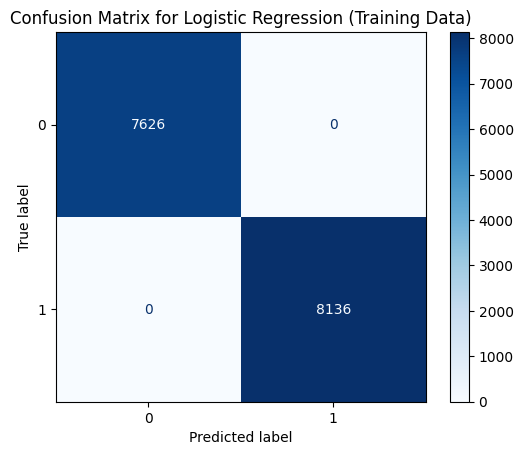


Model: Logistic Regression (Test Data)
Test Accuracy: 0.99
Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3376
           1       0.98      0.99      0.99      3604

    accuracy                           0.99      6980
   macro avg       0.99      0.99      0.99      6980
weighted avg       0.99      0.99      0.99      6980



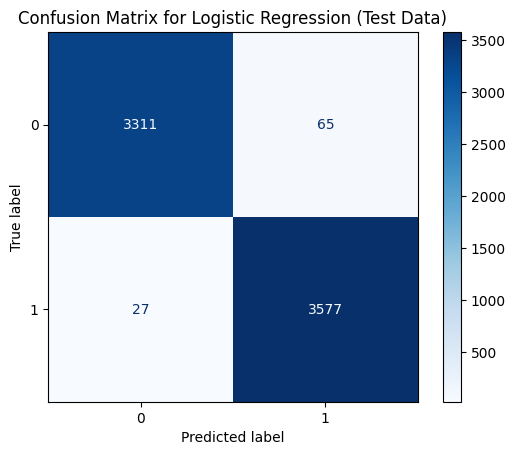


Model: Random Forest (Training Data)
Training Accuracy: 1.00
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7626
           1       1.00      1.00      1.00      8136

    accuracy                           1.00     15762
   macro avg       1.00      1.00      1.00     15762
weighted avg       1.00      1.00      1.00     15762



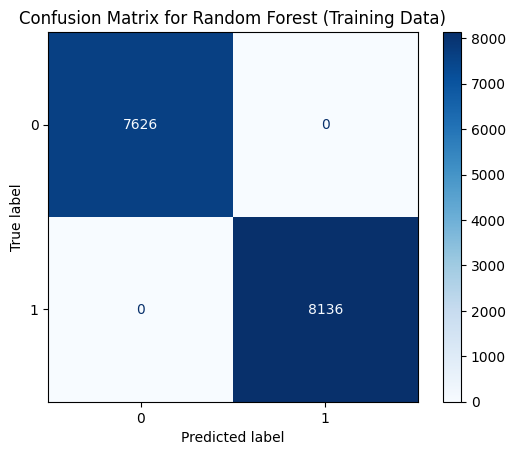


Model: Random Forest (Test Data)
Test Accuracy: 1.00
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3376
           1       1.00      1.00      1.00      3604

    accuracy                           1.00      6980
   macro avg       1.00      1.00      1.00      6980
weighted avg       1.00      1.00      1.00      6980



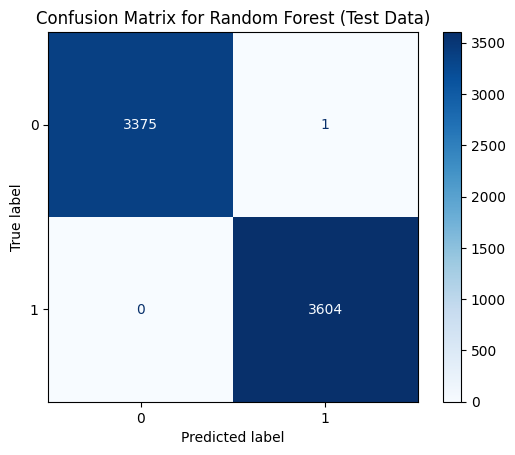


Model: Support Vector Classifier (Training Data)
Training Accuracy: 1.00
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7626
           1       1.00      1.00      1.00      8136

    accuracy                           1.00     15762
   macro avg       1.00      1.00      1.00     15762
weighted avg       1.00      1.00      1.00     15762



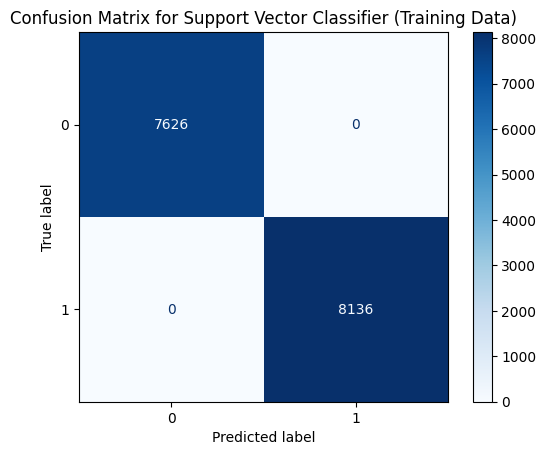


Model: Support Vector Classifier (Test Data)
Test Accuracy: 0.91
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3376
           1       0.86      1.00      0.92      3604

    accuracy                           0.91      6980
   macro avg       0.93      0.91      0.91      6980
weighted avg       0.93      0.91      0.91      6980



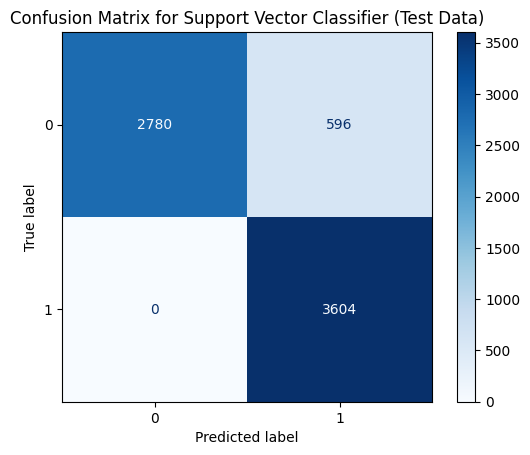


Model: Decision Tree (Training Data)
Training Accuracy: 1.00
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7626
           1       1.00      1.00      1.00      8136

    accuracy                           1.00     15762
   macro avg       1.00      1.00      1.00     15762
weighted avg       1.00      1.00      1.00     15762



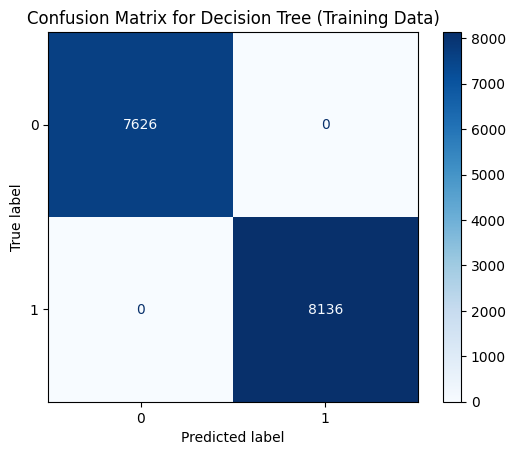


Model: Decision Tree (Test Data)
Test Accuracy: 0.86
Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      3376
           1       0.81      0.96      0.88      3604

    accuracy                           0.86      6980
   macro avg       0.88      0.86      0.86      6980
weighted avg       0.88      0.86      0.86      6980



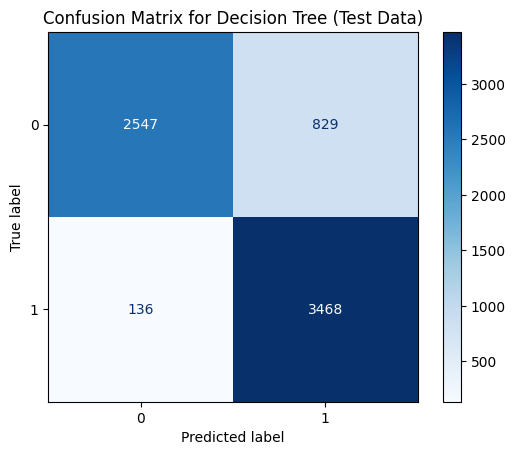


Model: K-Nearest Neighbors (Training Data)
Training Accuracy: 1.00
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7626
           1       1.00      1.00      1.00      8136

    accuracy                           1.00     15762
   macro avg       1.00      1.00      1.00     15762
weighted avg       1.00      1.00      1.00     15762



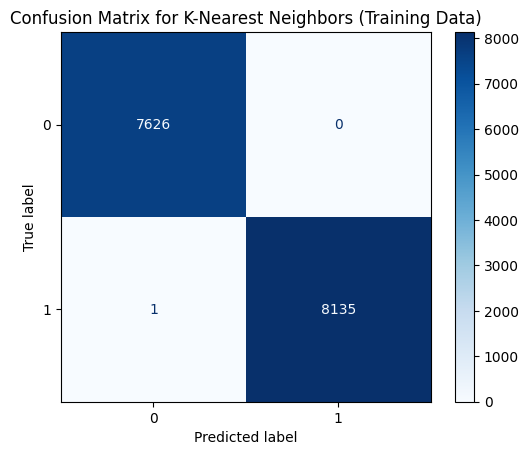


Model: K-Nearest Neighbors (Test Data)
Test Accuracy: 0.97
Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3376
           1       0.96      0.99      0.97      3604

    accuracy                           0.97      6980
   macro avg       0.97      0.97      0.97      6980
weighted avg       0.97      0.97      0.97      6980



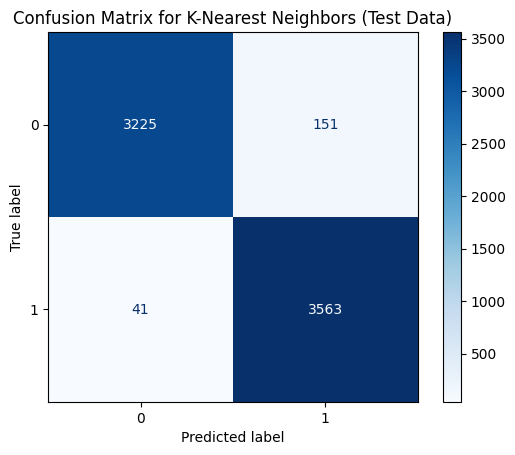


Model: Naive Bayes (Training Data)
Training Accuracy: 0.70
Training Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.98      0.76      7626
           1       0.96      0.43      0.59      8136

    accuracy                           0.70     15762
   macro avg       0.79      0.71      0.68     15762
weighted avg       0.80      0.70      0.67     15762



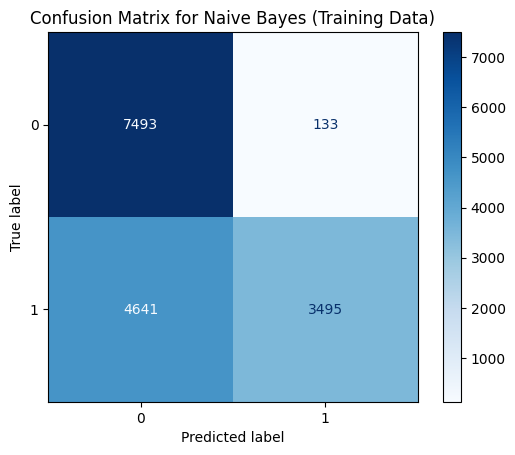


Model: Naive Bayes (Test Data)
Test Accuracy: 0.66
Test Classification Report:
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      3376
           1       1.00      0.35      0.52      3604

    accuracy                           0.66      6980
   macro avg       0.79      0.67      0.63      6980
weighted avg       0.80      0.66      0.63      6980



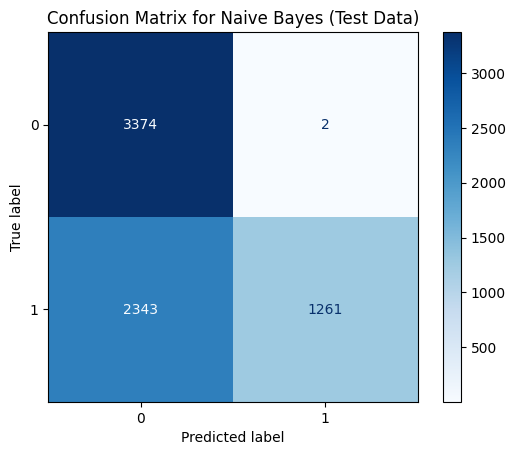


Model: Gradient Boosting (Training Data)
Training Accuracy: 1.00
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7626
           1       1.00      1.00      1.00      8136

    accuracy                           1.00     15762
   macro avg       1.00      1.00      1.00     15762
weighted avg       1.00      1.00      1.00     15762



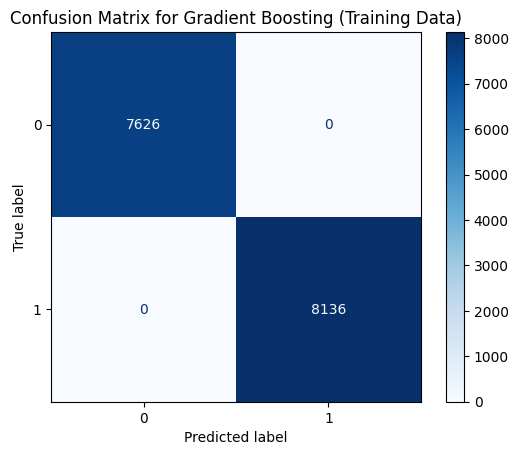


Model: Gradient Boosting (Test Data)
Test Accuracy: 0.91
Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      3376
           1       0.86      0.99      0.92      3604

    accuracy                           0.91      6980
   macro avg       0.92      0.91      0.91      6980
weighted avg       0.92      0.91      0.91      6980



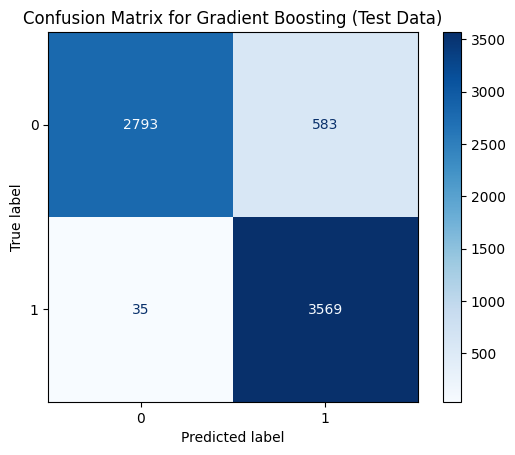


Model: AdaBoost (Training Data)
Training Accuracy: 1.00
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7626
           1       1.00      1.00      1.00      8136

    accuracy                           1.00     15762
   macro avg       1.00      1.00      1.00     15762
weighted avg       1.00      1.00      1.00     15762



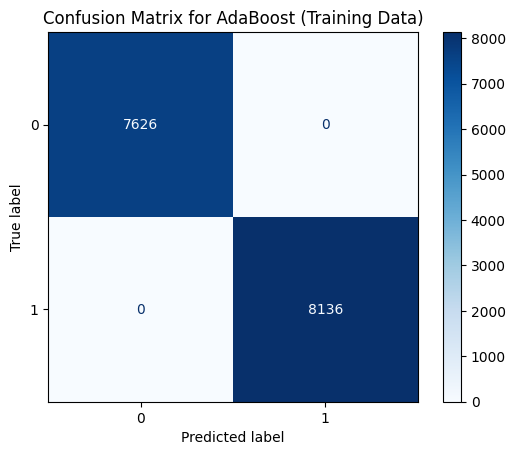


Model: AdaBoost (Test Data)
Test Accuracy: 0.89
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      3376
           1       0.82      1.00      0.90      3604

    accuracy                           0.89      6980
   macro avg       0.91      0.88      0.89      6980
weighted avg       0.91      0.89      0.89      6980



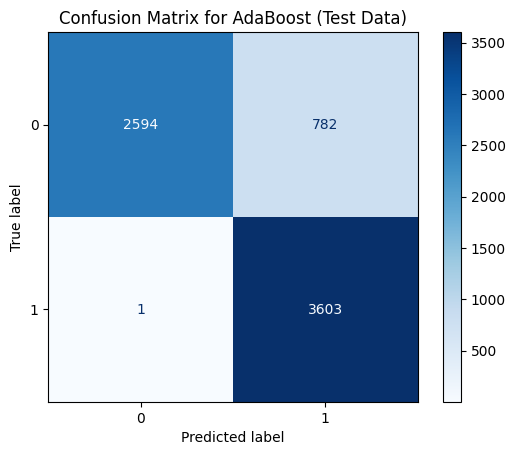


Model: Ridge Classifier (Training Data)
Training Accuracy: 0.99
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7626
           1       0.99      1.00      1.00      8136

    accuracy                           0.99     15762
   macro avg       1.00      0.99      0.99     15762
weighted avg       0.99      0.99      0.99     15762



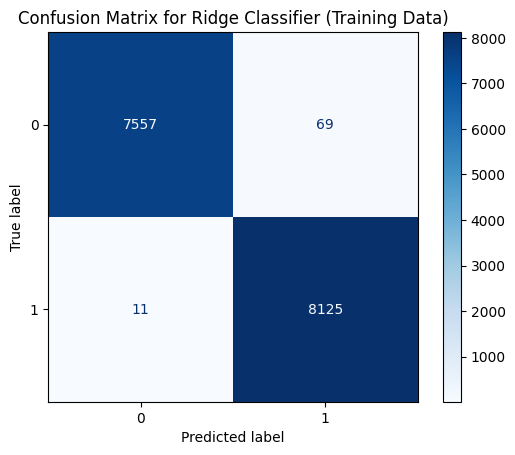


Model: Ridge Classifier (Test Data)
Test Accuracy: 0.83
Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79      3376
           1       0.76      0.99      0.86      3604

    accuracy                           0.83      6980
   macro avg       0.87      0.82      0.82      6980
weighted avg       0.87      0.83      0.82      6980



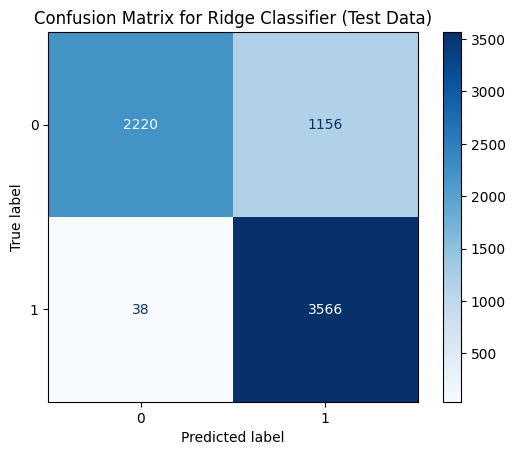


Model: XGBoost (Training Data)
Training Accuracy: 1.00
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7626
           1       1.00      1.00      1.00      8136

    accuracy                           1.00     15762
   macro avg       1.00      1.00      1.00     15762
weighted avg       1.00      1.00      1.00     15762



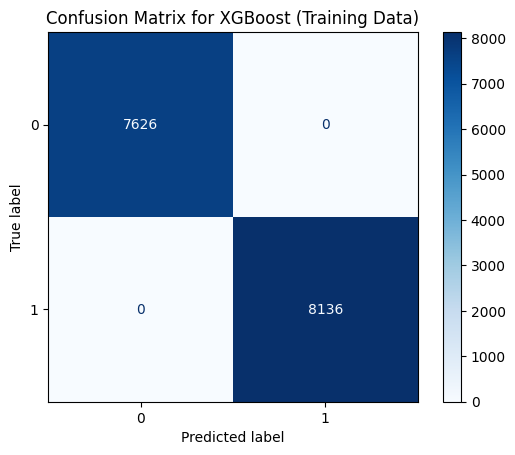


Model: XGBoost (Test Data)
Test Accuracy: 0.92
Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      3376
           1       0.88      0.99      0.93      3604

    accuracy                           0.92      6980
   macro avg       0.93      0.92      0.92      6980
weighted avg       0.93      0.92      0.92      6980



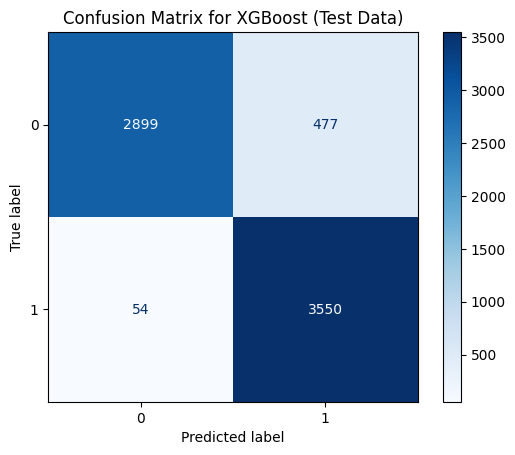


Best Model: Random Forest with Test Accuracy: 1.00


In [28]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Classifier": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Ridge Classifier": RidgeClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}
def train_and_evaluate_models(x_train, y_train, x_test, y_test):
    best_model = None
    best_model_name = ""
    highest_accuracy = 0
    
    for model_name, model in classifiers.items():
        model.fit(x_train, y_train)
        
        # Evaluate on training data
        y_train_pred = model.predict(x_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_cm = confusion_matrix(y_train, y_train_pred)
        
        print(f"\nModel: {model_name} (Training Data)")
        print(f"Training Accuracy: {train_accuracy:.2f}")
        train_report = classification_report(y_train, y_train_pred)
        print("Training Classification Report:")
        print(train_report)
        
        # Plot confusion matrix for training data
        train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.unique(y_train))
        train_disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_name} (Training Data)')
        plt.show()
        
        # Evaluate on test data
        y_test_pred = model.predict(x_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_cm = confusion_matrix(y_test, y_test_pred)
        
        print(f"\nModel: {model_name} (Test Data)")
        print(f"Test Accuracy: {test_accuracy:.2f}")
        test_report = classification_report(y_test, y_test_pred)
        print("Test Classification Report:")
        print(test_report)
        
        # Plot confusion matrix for test data
        test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.unique(y_test))
        test_disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {model_name} (Test Data)')
        plt.show()
        
        # Check for the best model
        if test_accuracy > highest_accuracy:
            highest_accuracy = test_accuracy
            best_model = model
            best_model_name = model_name
    
    print(f"\nBest Model: {best_model_name} with Test Accuracy: {highest_accuracy:.2f}")
    return best_model
# Run the function to train and evaluate all models
best_model = train_and_evaluate_models(x_train_scaled, y_train, x_test_scaled, y_test)

In [29]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_model, x_train_scaled, y_train, cv=5, scoring='accuracy')

# Display cross-validation results
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")


Cross-Validation Accuracy: 0.99 ± 0.01


Explained Variance Ratios: [2.85214438e-01 7.73615099e-02 6.14668664e-02 5.76088246e-02
 5.53701912e-02 4.94129281e-02 4.32240851e-02 3.50419773e-02
 2.97983267e-02 2.82962131e-02 2.56013883e-02 2.42717361e-02
 2.28324412e-02 2.05668091e-02 2.02662808e-02 1.78176136e-02
 1.66142832e-02 1.47082618e-02 1.43198554e-02 1.23000451e-02
 1.20618510e-02 1.12449468e-02 1.08680941e-02 8.90773336e-03
 8.21562705e-03 7.58398583e-03 6.13102151e-03 5.19380554e-03
 4.51779278e-03 4.09732639e-03 3.76569034e-03 1.88755849e-03
 1.55323045e-03 1.09429041e-03 7.66877629e-04 1.54079445e-05
 6.85722946e-07 1.37926428e-33 1.37926428e-33 1.37926428e-33]


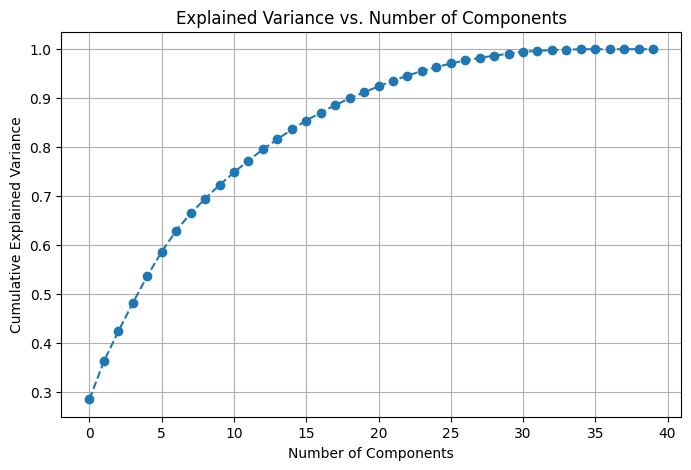

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
pca = PCA()  # Without specifying n_components, it keeps all components
pca.fit(x_train_scaled)

# Explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)
# Cumulative variance plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

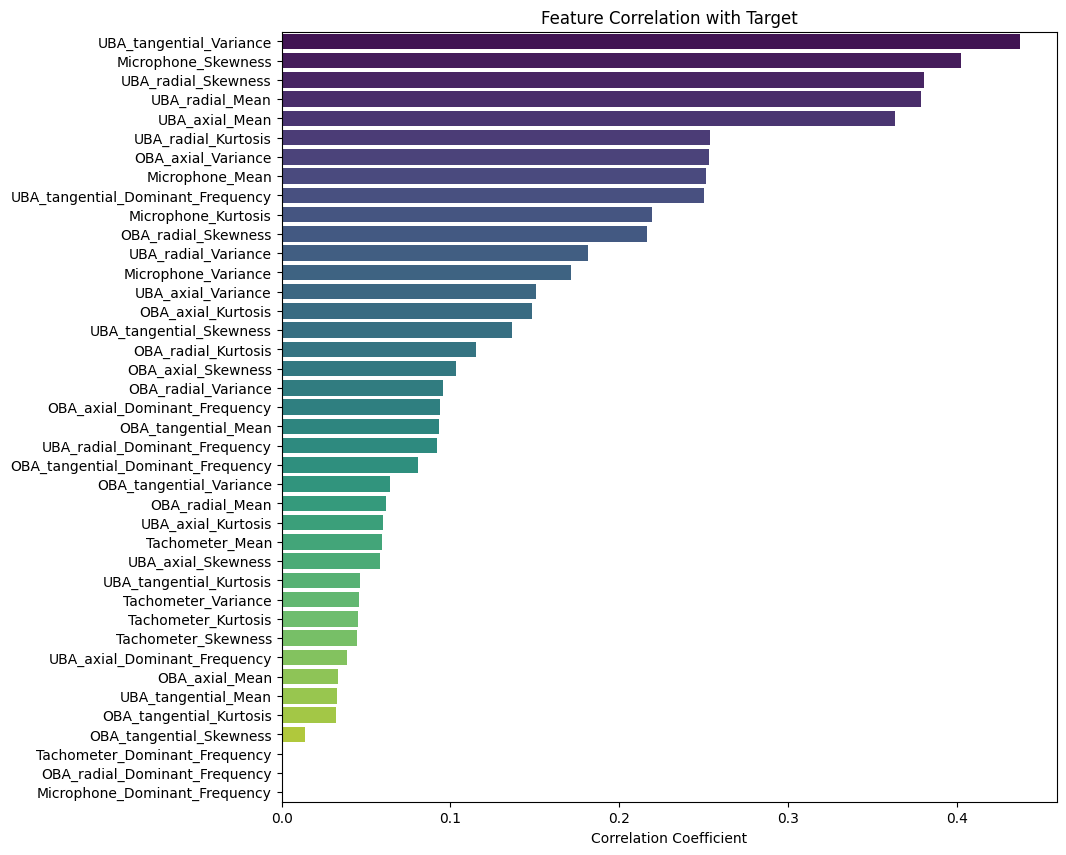

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine features and target into one DataFrame (assuming X and y are separate)
data = pd.concat([x_train, y_train], axis=1)

# Compute correlation matrix
correlation_matrix = data.corr()

# Extract correlations with the target variable
target_corr = correlation_matrix['Fault'].drop('Fault')  # Replace 'output' with your target column name

# Sort and visualize
target_corr_sorted = target_corr.abs().sort_values(ascending=False)
plt.figure(figsize=(10, 10))
sns.barplot(x=target_corr_sorted.values, y=target_corr_sorted.index, palette="viridis")
plt.title("Feature Correlation with Target")
plt.xlabel("Correlation Coefficient")
plt.show()


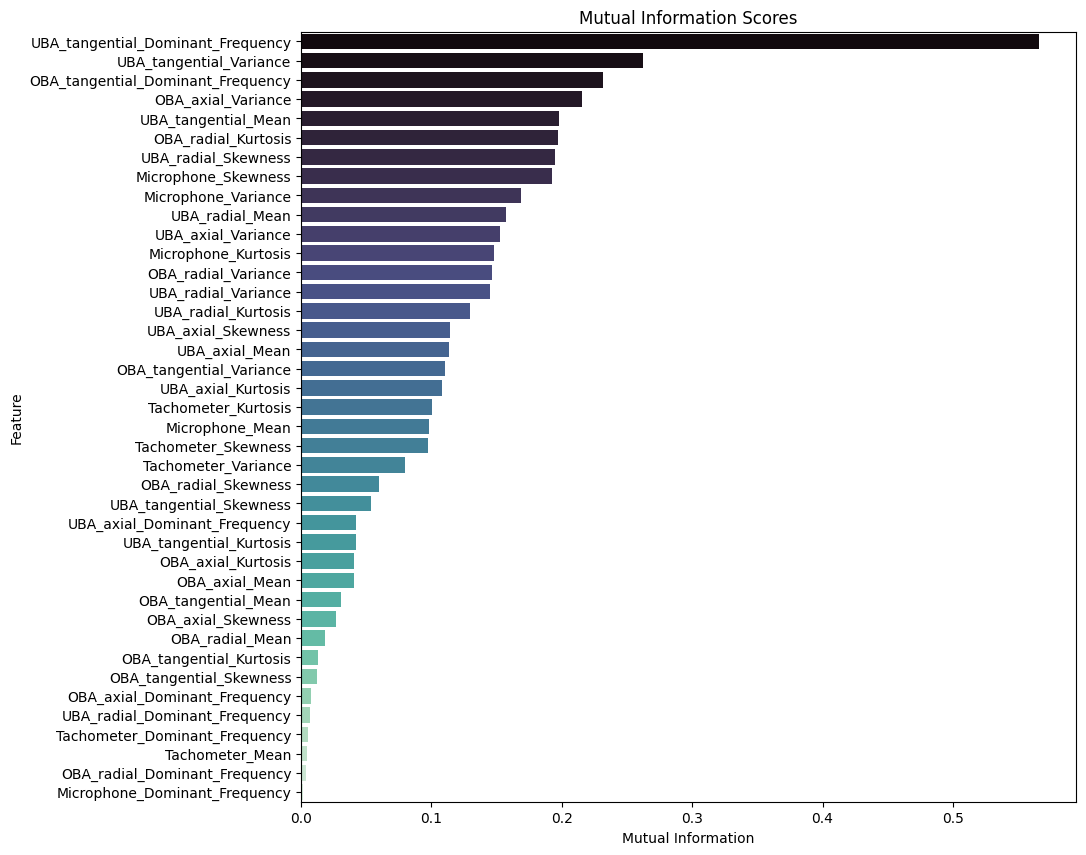

In [41]:
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information
mi_scores = mutual_info_classif(x_train, y_train)

# Create DataFrame for visualization
mi_df = pd.DataFrame({'Feature': x_train.columns, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Plot
plt.figure(figsize=(10, 10))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df, palette='mako')
plt.title("Mutual Information Scores")
plt.show()
